__version__

__verSN:1__<br>
__Image__<br>
metaval:resizeのみ<br>
192_192：OOF: 0.869 Wall time:  1h 33min LB: 0.861<br>
224_224：OOF: 0.883 Wall time:  2h 07min LB: 0.862<br>
256_256：OOF: 0.875 Wall time:  2h 36min LB: 0.882<br>
382_382：OOF: 0.869 Wall time:  5h 10min LB: 0.854<br>
512_512：OOF: 0.848 Wall time: 10h 29min LB: 0.852<br>
__Table__<br>
patientid有、isnan有<br>
lgb: CV mean score: 0.7306, std: 0.0175., LB: 0.6637<br>
SVC: CV mean score: 0.6622, std: 0.0276., LB: 0.6637<br>
__Blending__<br>
blending model<br>
lgb: CV mean score: 0.8838, std: 0.0172., LB: 0.8642<br>
SVC: CV mean score: 0.8103, std: 0.0634., LB: 0.8342<br>
BayesianOptimization<br>
init_points = 50, n_iter = 10, CV:0.8981, LB:0.8811<br>
init_points = 50, n_iter = 40, CV:0.8981, LB:0.8989<br>
init_points = 100, n_iter = 30, CV:0.8983, LB:0.8813<br>
__verSN:3__<br>
__Stacking__<br>
Stacking model<br>
第一層最高スコア：
192_192：OOF: 0.893 Wall time: 2h 10min 17s LB: 0.8813<br>
BayesianOptimization<br>
init_points = 100, n_iter = 30, CV:0.9160, LB:0.8874<br>
init_points = 50, n_iter = 40, CV:0.9159, LB:0.8875<br>
__verSN:4__<br>
tfrecordによるfold + epoch20<br>
第一層最高スコア：
128_128：OOF: 0.882 Wall time: 1h 20min 49s LB:0.8929 <br>
BayesianOptimization<br>
init_points = 50, n_iter = 40, CV:0.9042, LB:0.8945<br>

__initialize__

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

from kaggle.api.kaggle_api_extended import KaggleApi
import os
from  bayes_opt  import  BayesianOptimization
import warnings

In [2]:
# config
melanoma_external_malignant_256 = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/melanoma_external_malignant_256/"
SIIM_ISIC_Melanoma_Classification = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/SIIM-ISIC-Melanoma-Classification/"
Output = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/Output/"

__preprocessing__

In [5]:
#学習用(metaval)/予測用(test)のテーブルデータ作成
def generateTable(modelMtx, TrainOrTest):
    if TrainOrTest == "test":
        folder = 'test/sub_test_'
        Table = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'test.csv')
        Table = Table[["image_name"]]
        
    elif TrainOrTest == "train":
        folder = 'metaval/sub_metaval_'
        #Table = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'metaval.csv')
        Table = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train.csv')
        Table = Table[Table.tfrecord != -1]
        Table = Table.reset_index(drop=True)
        Table = Table[["image_name", "target"]]
    else:
        print("err:TrainOrTest is only 'train' or 'test'")
    
    for modelNM in modelMtx:
        Tb_temp = pd.read_csv(Output + folder + modelNM + '.csv')
        Tb_temp = Tb_temp.rename(columns={'target':'pred_' + modelNM})
        Table = pd.merge(Table, Tb_temp, on="image_name", how="inner")
    
    return Table

In [6]:
modelMtx = ['stacking_64_64', 'stacking_96_96', 'stacking_128_128', 'stacking_160_160', 'stacking_192_192']
MVTable = generateTable(modelMtx = modelMtx, TrainOrTest = "train")
TestTable = generateTable(modelMtx = modelMtx, TrainOrTest = "test")

In [7]:
MVTable

,image_name,target,pred_stacking_64_64,pred_stacking_96_96,pred_stacking_128_128,pred_stacking_160_160,pred_stacking_192_192
0,ISIC_2637011,0,2.542518e-04,0.000073,0.000663,0.000280,0.000244
1,ISIC_0015719,0,5.107879e-05,0.000150,0.000019,0.000006,0.000026
2,ISIC_0052212,0,2.654362e-05,0.000030,0.000012,0.000096,0.000296
3,ISIC_0068279,0,3.180563e-04,0.000102,0.000027,0.003673,0.000306
4,ISIC_0074268,0,3.063538e-09,0.000274,0.000276,0.000248,0.000066
...,...,...,...,...,...,...,...
32687,ISIC_9999134,0,0.000000e+00,0.000000,0.000000,0.000000,0.000000
32688,ISIC_9999320,0,0.000000e+00,0.000000,0.000000,0.000000,0.000000
32689,ISIC_9999515,0,0.000000e+00,0.000000,0.000000,0.000000,0.000000
32690,ISIC_9999666,0,0.000000e+00,0.000000,0.000000,0.000000,0.000000


In [8]:
MVTable[MVTable.target == 1]

,image_name,target,pred_stacking_64_64,pred_stacking_96_96,pred_stacking_128_128,pred_stacking_160_160,pred_stacking_192_192
91,ISIC_0149568,1,0.000148,0.000089,0.000080,0.000134,0.000361
235,ISIC_0188432,1,0.131746,0.023332,0.060053,0.070242,0.018949
314,ISIC_0207268,1,0.003509,0.001744,0.006967,0.002109,0.006436
399,ISIC_0232101,1,0.064557,0.057155,0.030839,0.038145,0.038472
459,ISIC_0247330,1,0.007008,0.002558,0.003712,0.000059,0.002430
...,...,...,...,...,...,...,...
32409,ISIC_9910791,1,0.026637,0.261981,0.116740,0.023513,0.020905
32536,ISIC_9955163,1,0.019845,0.122747,0.055658,0.061902,0.120427
32567,ISIC_9963177,1,0.005939,0.008116,0.020201,0.001160,0.003498
32616,ISIC_9978107,1,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
TestTable

,image_name,pred_stacking_64_64,pred_stacking_96_96,pred_stacking_128_128,pred_stacking_160_160,pred_stacking_192_192
0,ISIC_0052060,0.001755,0.000083,0.000028,9.026283e-07,0.000046
1,ISIC_0052349,0.000156,0.000007,0.000007,1.754260e-05,0.000009
2,ISIC_0058510,0.000072,0.000006,0.000009,6.276972e-07,0.000016
3,ISIC_0073313,0.000080,0.000036,0.000028,2.867150e-06,0.000012
4,ISIC_0073502,0.000166,0.000008,0.000068,2.446350e-05,0.000073
...,...,...,...,...,...,...
10977,ISIC_9992485,0.000000,0.000000,0.000000,0.000000e+00,0.000000
10978,ISIC_9996992,0.000000,0.000000,0.000000,0.000000e+00,0.000000
10979,ISIC_9997917,0.000000,0.000000,0.000000,0.000000e+00,0.000000
10980,ISIC_9998234,0.000000,0.000000,0.000000,0.000000e+00,0.000000


__model__

In [10]:
# bayes test
#parameter(重み)の範囲を定義。
params = {}
for c in MVTable.columns.drop(['target','image_name']):
    params[c] = (0, 1)

In [11]:
params

{'pred_stacking_64_64': (0, 1),
 'pred_stacking_96_96': (0, 1),
 'pred_stacking_128_128': (0, 1),
 'pred_stacking_160_160': (0, 1),
 'pred_stacking_192_192': (0, 1)}

In [12]:
#最大化させたい関数
def ROC_evaluate(**params):
    warnings.simplefilter('ignore')
    
    s = sum(params.values())
    for p in params:
        params[p] = params[p] / s
    
    test_pred_proba = pd.Series(np.zeros(MVTable.shape[0]), index = MVTable.index)
    
    feats = [f for f in MVTable.columns if f not in ['target','image_name', 'index']]
    
    for f in feats:
        test_pred_proba += MVTable[f] * params[f]
    
    return roc_auc_score(MVTable['target'], test_pred_proba)

In [13]:
def fitBayesian(MVTable, TestTable, init_points, n_iter):
    params = {}
    for c in MVTable.columns.drop(['target','image_name']):
        params[c] = (0, 1)
        
    bo = BayesianOptimization(ROC_evaluate, params)
    #init_points:random explorationのステップ数。exploration space(探索空間)に多様性をもたらす。
    #n_iter:bayesian optimizationのステップ数
    bo.maximize(init_points = init_points, n_iter = n_iter)
    best_params = bo.max['params']
    best_normalized_params = {}
    
    s = sum(best_params.values())
    for p in best_params:
        best_normalized_params[p] = best_params[p] / s

    prediction_train = pd.Series(np.zeros(MVTable.shape[0]), index = MVTable.index)
    prediction_test = pd.Series(np.zeros(TestTable.shape[0]), index = TestTable.index)
        
    feats = [f for f in MVTable.columns if f not in ['target','image_name', 'index']]
        
    for f in feats:
        prediction_train += MVTable[f] * best_normalized_params[f]
        prediction_test += TestTable[f] * best_normalized_params[f]
        
    train_score = roc_auc_score(MVTable['target'], prediction_train)
    
    print("init_points = {0}, n_iter = {1}, CV:{2:.4f}".format(init_points, n_iter, train_score))
    
    return prediction_test

In [14]:
prediction_test = fitBayesian(MVTable, TestTable, init_points=50, n_iter=40)

csv_file_path = Output + 'submit/sub_stacking.csv'
sub = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')

sub.target = prediction_test
sub.to_csv(csv_file_path, index=False)

|   iter    |  target   | pred_s... | pred_s... | pred_s... | pred_s... | pred_s... |
-------------------------------------------------------------------------------------
|  1        |  0.9004   |  0.8966   |  0.4044   |  0.0514   |  0.7695   |  0.6805   |
|  2        |  0.903    |  0.7337   |  0.8063   |  0.4057   |  0.3047   |  0.9222   |
|  3        |  0.902    |  0.4252   |  0.09007  |  0.533    |  0.2399   |  0.06763  |
|  4        |  0.901    |  0.8608   |  0.02843  |  0.6945   |  0.3627   |  0.5965   |
|  5        |  0.9025   |  0.8843   |  0.7334   |  0.2972   |  0.06735  |  0.8095   |
|  6        |  0.9028   |  0.07702  |  0.2216   |  0.3497   |  0.2601   |  0.1635   |
|  7        |  0.9026   |  0.2996   |  0.6433   |  0.7577   |  0.8261   |  0.03255  |
|  8        |  0.9027   |  0.8377   |  0.334    |  0.9004   |  0.2817   |  0.8251   |
|  9        |  0.9041   |  0.8398   |  0.8484   |  0.5274   |  0.4957   |  0.152    |
|  10       |  0.9037   |  0.2252   |  0.6774   |  0.7

|  58       |  0.9039   |  0.8877   |  0.9736   |  0.9709   |  0.2723   |  0.05571  |
|  59       |  0.9025   |  0.934    |  0.915    |  0.9958   |  0.01301  |  0.02596  |
|  60       |  0.9032   |  0.9679   |  0.8768   |  0.9808   |  0.009671 |  0.1559   |
|  61       |  0.902    |  0.9423   |  0.8637   |  0.9382   |  0.000409 |  0.007799 |
|  62       |  0.9032   |  0.7951   |  0.952    |  0.9981   |  0.03778  |  0.957    |
|  63       |  0.9034   |  0.7808   |  0.9282   |  0.9785   |  0.007657 |  0.7965   |
|  64       |  0.9015   |  0.0749   |  0.9736   |  0.9811   |  0.01983  |  0.1837   |
|  65       |  0.9039   |  0.9093   |  0.9923   |  0.9239   |  0.2925   |  0.04068  |
|  66       |  0.9035   |  0.9923   |  0.9772   |  0.6551   |  0.958    |  0.05493  |
|  67       |  0.9036   |  0.9991   |  0.9719   |  0.9291   |  0.9342   |  0.722    |
|  68       |  0.904    |  0.9542   |  0.9362   |  0.9344   |  0.7431   |  0.4245   |
|  69       |  0.9041   |  0.9389   |  0.9863   |  0.9

In [15]:
#submit
api = KaggleApi()
api.authenticate()  # 認証を通す
message = "blending BayesianOptimization "
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

100%|██████████| 375k/375k [00:04<00:00, 84.0kB/s]


Successfully submitted to SIIM-ISIC Melanoma Classification

In [ ]:
# bayes test end

In [42]:
from sklearn import metrics
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import time
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

In [39]:
def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, 
                               plot_feature_importance=False, model=None, verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    :params: verbose - parameters for gradient boosting models
    :params: early_stopping_rounds - parameters for gradient boosting models
    :params: n_estimators - parameters for gradient boosting models
    
    """
    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    #X_metaval = X_metaval[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': 'auc',
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros((len(X), len(set(y.values))))
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test), oof.shape[1]))
    #prediction_MV = np.zeros((len(X_metaval), oof.shape[1]))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid, num_iteration=model.best_iteration_)
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)
            #y_pred_MV = model.predict_proba(X_metaval, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, 
                              early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict_proba(xgb.DMatrix(X_valid, feature_names=X.columns), 
                                         ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            #y_pred_MV = model.predict(xgb.DMatrix(X_metaval, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict_proba(X_valid)#.reshape(-1,)
            #print(len(y_pred_valid))
            #print(len(y_valid))
            #print(y_pred_valid)
            #print(y_valid)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid[:, 1])
            print(f'Fold {fold_n + 1}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
            #y_pred_MV = model.predict_proba(X_metaval)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
            #y_pred_MV = model.predict(X_metaval)
        
        #print(oof.shape)
        #print(oof[valid_index])
        oof[valid_index] = y_pred_valid
        scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid[:, 1]))#0 or 1の問題にしか対応してない

        prediction += y_pred    
        #prediction_MV += y_pred_MV    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    #prediction_MV /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    #result_dict['prediction_MV'] = prediction_MV
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict


__run__

In [10]:
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold

In [44]:
%%time
#SVM
#交差検証
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
m_type = "sklearn"

params = None
C = 0.09
gamma = 'auto'

#data
y = MVTable["target"]
X = MVTable.drop(['target','image_name'], axis=1)
X_test = TestTable.drop(['image_name'], axis=1)

#support vector machine
model = SVC(C=C, gamma=gamma, probability=True)
result_dict = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type=m_type, eval_metric='auc',
                                         plot_feature_importance=True, verbose=1000, early_stopping_rounds=200, n_estimators=10000, model = model)

csv_file_path = Output + 'submit/sub_blending.csv'
sub = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')

sub.target = result_dict["prediction"][:,1]
sub.to_csv(csv_file_path, index=False)



Fold 1 started at Sun Jul 19 16:44:41 2020
Fold 1. auc: 0.8720.

Fold 2 started at Sun Jul 19 16:44:41 2020
Fold 2. auc: 0.7798.

Fold 3 started at Sun Jul 19 16:44:41 2020
Fold 3. auc: 0.8699.

Fold 4 started at Sun Jul 19 16:44:42 2020
Fold 4. auc: 0.7029.

Fold 5 started at Sun Jul 19 16:44:42 2020
Fold 5. auc: 0.8268.

CV mean score: 0.8103, std: 0.0634.
CPU times: user 1.3 s, sys: 5.76 ms, total: 1.31 s
Wall time: 1.3 s


In [43]:
%%time
#Linear
#交差検証
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
m_type = "sklearn"

params = None

#data
y = MVTable["target"]
X = MVTable.drop(['target','image_name'], axis=1)
X_test = TestTable.drop(['image_name'], axis=1)

#support vector machine
model = LinearRegression()
result_dict = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type=m_type, eval_metric='auc',
                                         plot_feature_importance=True, verbose=1000, early_stopping_rounds=200, n_estimators=10000, model = model)

csv_file_path = Output + 'submit/sub_blending.csv'
sub = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')

sub.target = result_dict["prediction"][:,1]
sub.to_csv(csv_file_path, index=False)



Fold 1 started at Sun Jul 19 16:00:36 2020


AttributeError: 'LinearRegression' object has no attribute 'predict_proba'

Fold 1 started at Sun Jul 19 15:42:02 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0795649	training's auc: 0.964909	valid_1's binary_logloss: 0.0800094	valid_1's auc: 0.885671
Fold 2 started at Sun Jul 19 15:42:02 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.0629722	training's auc: 0.978919	valid_1's binary_logloss: 0.0756656	valid_1's auc: 0.856793
Fold 3 started at Sun Jul 19 15:42:03 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.0393994	training's auc: 0.995215	valid_1's binary_logloss: 0.0840326	valid_1's auc: 0.884971
Fold 4 started at Sun Jul 19 15:42:03 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.0771374	training's auc:

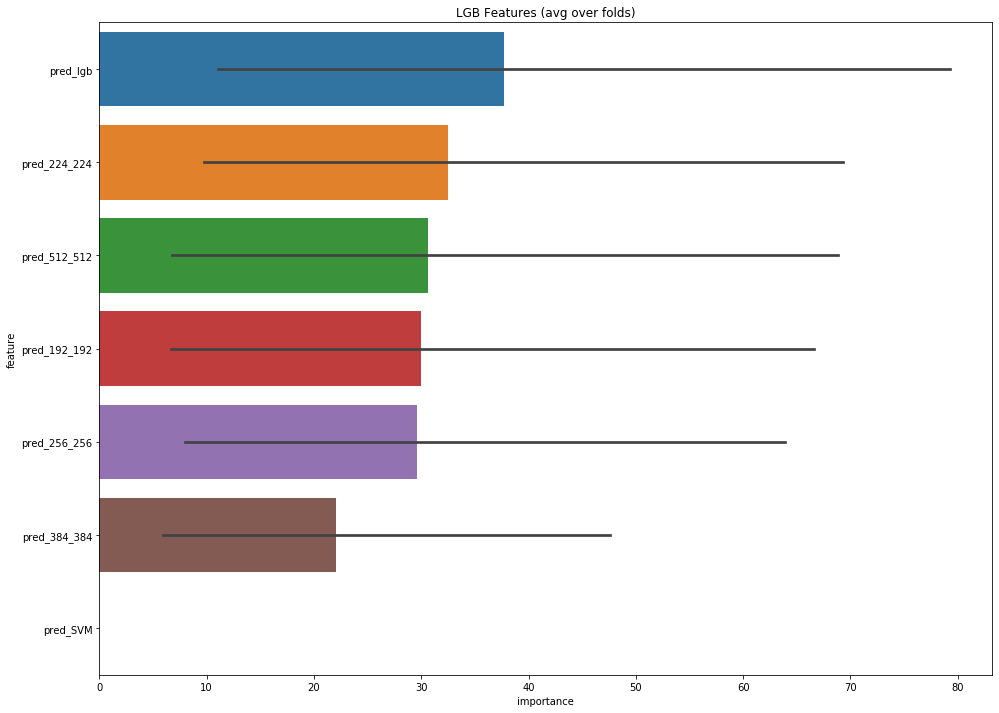

In [29]:
%%time
#lgb
#交差検証
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
m_type = "lgb"

params = {"boosting_type": "gbdt",
          "learning_rate": 0.01,
          #'max_depth': 7,
          #'num_leaves': 31,
          "subsample_freq": 1,
          "subsample": 0.9,
          #'reg_alpha': 0,
          #'reg_lambda': 0,
         }

#data
y = MVTable["target"]
X = MVTable.drop(['target','image_name'], axis=1)
X_test = TestTable.drop(['image_name'], axis=1)

#lgb(決定木)で学習実行
result_dict = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type=m_type, eval_metric='auc',
                                         plot_feature_importance=True, verbose=1000, early_stopping_rounds=200, n_estimators=10000)


csv_file_path = Output + 'submit/sub_blending.csv'
sub = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')

sub.target = result_dict["prediction"][:,1]
sub.to_csv(csv_file_path, index=False)

In [40]:
%%time
#xgb
#交差検証
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
m_type = "cat"

params = {"boosting_type": "gbdt",
          "learning_rate": 0.01,
          #'max_depth': 7,
          #'num_leaves': 31,
          "subsample_freq": 1,
          "subsample": 0.9,
          #'reg_alpha': 0,
          #'reg_lambda': 0,
         }

#data
y = MVTable["target"]
X = MVTable.drop(['target','image_name'], axis=1)
X_test = TestTable.drop(['image_name'], axis=1)

#lgb(決定木)で学習実行
result_dict = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type=m_type, eval_metric='auc',
                                         plot_feature_importance=True, verbose=1000, early_stopping_rounds=200, n_estimators=10000)


csv_file_path = Output + 'submit/sub_blending.csv'
sub = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')

sub.target = result_dict["prediction"][:,1]
sub.to_csv(csv_file_path, index=False)

Fold 1 started at Sun Jul 19 15:54:39 2020


TypeError: __init__() got an unexpected keyword argument 'subsample_freq'

In [45]:
#submit
api = KaggleApi()
api.authenticate()  # 認証を通す
message = "blending"
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

100%|██████████| 355k/355k [00:03<00:00, 91.7kB/s]


Successfully submitted to SIIM-ISIC Melanoma Classification